In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns


In [2]:
DATAFOLDER = Path("../data")
FIGSFOLDER = Path("../figs")

masksfile = DATAFOLDER / "ME_PLVAP1_seg.npy"
imagefile = DATAFOLDER / "ME_PLVAP1.tif"

# masksfile = DATAFOLDER / "control11_seg.npy"
# imagefile = DATAFOLDER / "control11.tif"

In [3]:
data = np.load(masksfile, allow_pickle=True).item()
image = np.array(Image.open(imagefile))


In [4]:
image.shape

(768, 1024)

In [5]:
data["masks"].shape

(768, 1024)

In [77]:
pixels_per_profile = 100

masks = data["masks"]
centroids = {}
horizontal_profiles = {}
vertical_profiles = {}
diagonal_45_profiles = {}   # profiles at +45 degrees (bottom-left to top-right)
diagonal_135_profiles = {}  # profiles at -45 degrees (top-left to bottom-right)

for label in range(1, int(masks.max()) + 1):
    single_mask = masks == label
    if not np.any(single_mask):
        continue
    ys, xs = np.nonzero(single_mask)
    cy = float(ys.mean())
    cx = float(xs.mean())
    centroids[label] = (cx, cy)

    # Horizontal profile (along x-axis)
    xvals = (cx - pixels_per_profile / 2, cx + pixels_per_profile / 2)
    yvals = (cy - pixels_per_profile / 2, cy + pixels_per_profile / 2)
    
    if xvals[0] > 0 and xvals[1] < 1024:
        horizontal_profiles[label] = image[int(cy), int(xvals[0]):int(xvals[1])]
    
    # Vertical profile (along y-axis)
    if yvals[0] > 0 and yvals[1] < 768:
        vertical_profiles[label] = image[int(yvals[0]):int(yvals[1]), int(cx)]

    # Diagonal profiles at 45 degrees
    # For 45°: move diagonally (dx=1, dy=1) from center
    # For 135°: move diagonally (dx=1, dy=-1) from center
    half_len = pixels_per_profile / 2
    
    # 45-degree profile (↗ direction: x increases, y decreases in image coords)
    x_coords_45 = np.linspace(cx - half_len, cx + half_len, pixels_per_profile)
    y_coords_45 = np.linspace(cy - half_len, cy + half_len, pixels_per_profile)
    
    # Check bounds
    if (x_coords_45.min() >= 0 and x_coords_45.max() < image.shape[1] and 
        y_coords_45.min() >= 0 and y_coords_45.max() < image.shape[0]):
        # Sample along the diagonal using bilinear interpolation
        from scipy.ndimage import map_coordinates
        diagonal_45_profiles[label] = map_coordinates(
            image, 
            [y_coords_45, x_coords_45], 
            order=1
        )
    
    # 135-degree profile (↘ direction: x increases, y increases)
    x_coords_135 = np.linspace(cx - half_len, cx + half_len, pixels_per_profile)
    y_coords_135 = np.linspace(cy + half_len, cy - half_len, pixels_per_profile)
    
    # Check bounds
    if (x_coords_135.min() >= 0 and x_coords_135.max() < image.shape[1] and 
        y_coords_135.min() >= 0 and y_coords_135.max() < image.shape[0]):
        diagonal_135_profiles[label] = map_coordinates(
            image, 
            [y_coords_135, x_coords_135], 
            order=1
        )

# centroids

In [78]:
import trompy as tp

def remove_artifacts(profiles_dict, threshold=150):
    cleaned_profiles = {}
    for label, profile in profiles_dict.items():
        if np.max(profile) > threshold:  # assuming artifacts are very bright pixels
            print("Removing label", label)
        else:
            cleaned_profiles[label] = profile
    
    print(len(profiles_dict), len(cleaned_profiles))
    return cleaned_profiles

horizontal_profiles = remove_artifacts(horizontal_profiles)
vertical_profiles = remove_artifacts(vertical_profiles)
diagonal_45_profiles = remove_artifacts(diagonal_45_profiles)
diagonal_135_profiles = remove_artifacts(diagonal_135_profiles)

26 26
26 26
25 25
25 25


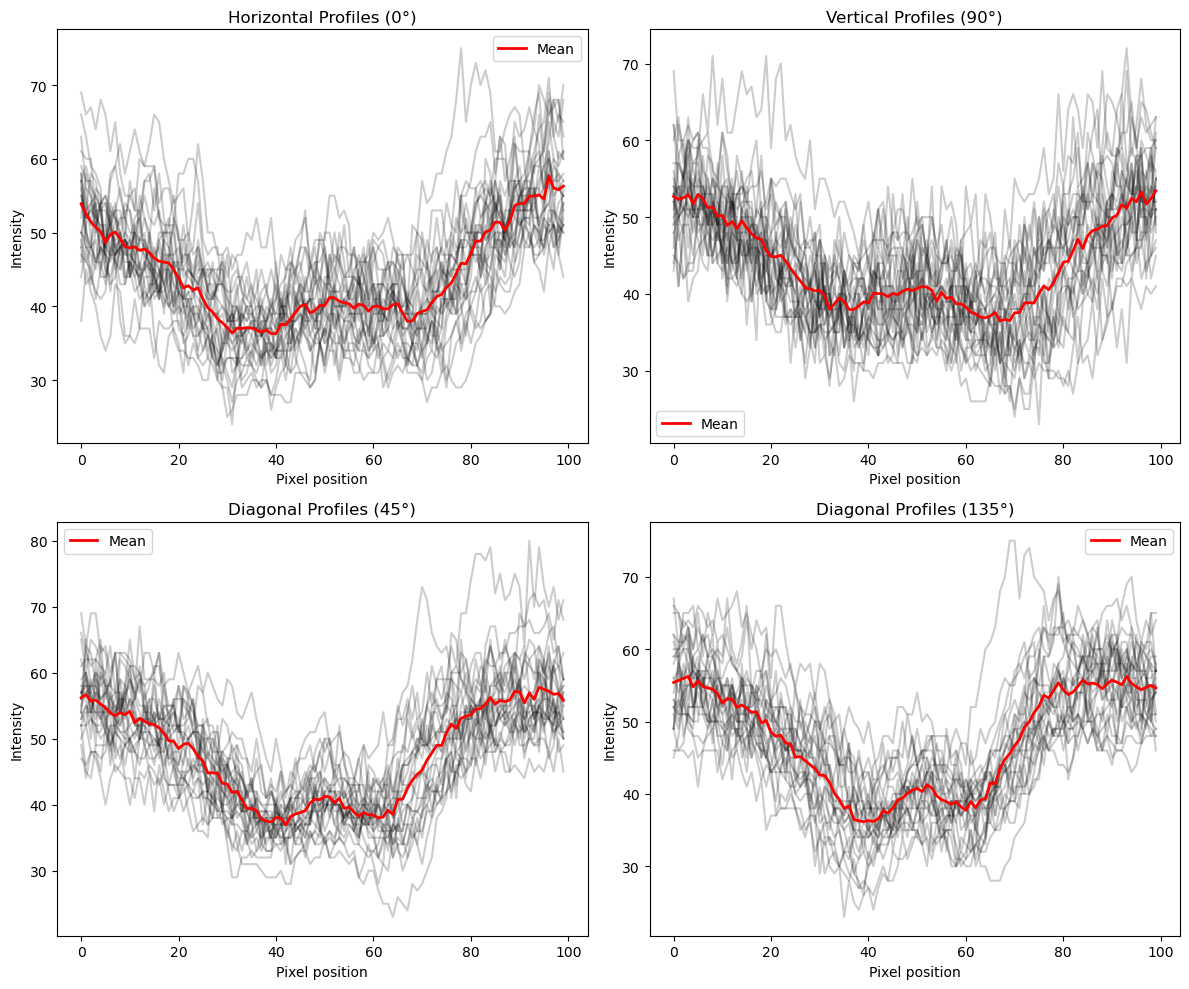

Horizontal: 26 profiles
Vertical: 26 profiles
Diagonal 45°: 25 profiles
Diagonal 135°: 25 profiles


In [79]:
# Visualize all four profile types
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Horizontal profiles
ax = axes[0, 0]
for idx, profile in horizontal_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if horizontal_profiles:
    h_array = np.vstack(list(horizontal_profiles.values()))
    ax.plot(np.mean(h_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Horizontal Profiles (0°)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()

# Vertical profiles
ax = axes[0, 1]
for idx, profile in vertical_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if vertical_profiles:
    v_array = np.vstack(list(vertical_profiles.values()))
    ax.plot(np.mean(v_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Vertical Profiles (90°)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()

# 45-degree diagonal profiles
ax = axes[1, 0]
for idx, profile in diagonal_45_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if diagonal_45_profiles:
    d45_array = np.vstack(list(diagonal_45_profiles.values()))
    ax.plot(np.mean(d45_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Diagonal Profiles (45°)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()

# 135-degree diagonal profiles
ax = axes[1, 1]
for idx, profile in diagonal_135_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if diagonal_135_profiles:
    d135_array = np.vstack(list(diagonal_135_profiles.values()))
    ax.plot(np.mean(d135_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Diagonal Profiles (135°)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Horizontal: {len(horizontal_profiles)} profiles")
print(f"Vertical: {len(vertical_profiles)} profiles")
print(f"Diagonal 45°: {len(diagonal_45_profiles)} profiles")
print(f"Diagonal 135°: {len(diagonal_135_profiles)} profiles")

Total profiles combined: 102
Combined array shape: (102, 100)
Mean profile shape: (100,)


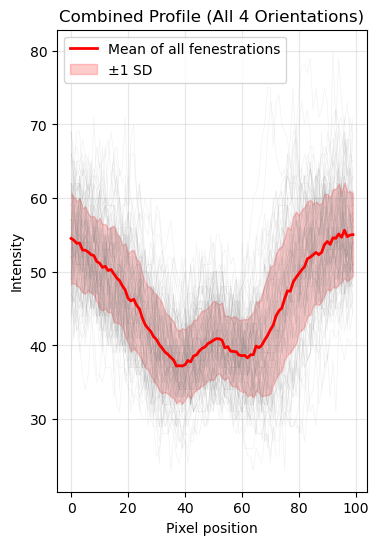

In [80]:
# Combine all four profile orientations into a single profile
all_profiles = []

# Add all profiles from each orientation
if horizontal_profiles:
    all_profiles.extend(list(horizontal_profiles.values()))
if vertical_profiles:
    all_profiles.extend(list(vertical_profiles.values()))
if diagonal_45_profiles:
    all_profiles.extend(list(diagonal_45_profiles.values()))
if diagonal_135_profiles:
    all_profiles.extend(list(diagonal_135_profiles.values()))

# Convert to 2D array and compute mean
combined_profiles_array = np.vstack(all_profiles)
combined_mean_profile = np.mean(combined_profiles_array, axis=0)
combined_std_profile = np.std(combined_profiles_array, axis=0)

# Visualize
fig, ax = plt.subplots(figsize=(4, 6))

# Plot all individual profiles
for profile in all_profiles:
    ax.plot(profile, color='gray', alpha=0.1, linewidth=0.5)

# Plot mean with standard deviation band
x = np.arange(len(combined_mean_profile))
ax.plot(combined_mean_profile, color='red', linewidth=2, label='Mean of all fenestrations')
ax.fill_between(x, 
                 combined_mean_profile - combined_std_profile, 
                 combined_mean_profile + combined_std_profile, 
                 color='red', alpha=0.2, label='±1 SD')

ax.set_title('Combined Profile (All 4 Orientations)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()
ax.grid(True, alpha=0.3)
# ax.set_ylim([20, 82])

# sns.despine(ax=ax, offset=10)

print(f"Total profiles combined: {len(all_profiles)}")
print(f"Combined array shape: {combined_profiles_array.shape}")
print(f"Mean profile shape: {combined_mean_profile.shape}")

fig.savefig(FIGSFOLDER / "median_eminence.png")
# fig.savefig(FIGSFOLDER / "cortex.png")

Shape: (10, 100)


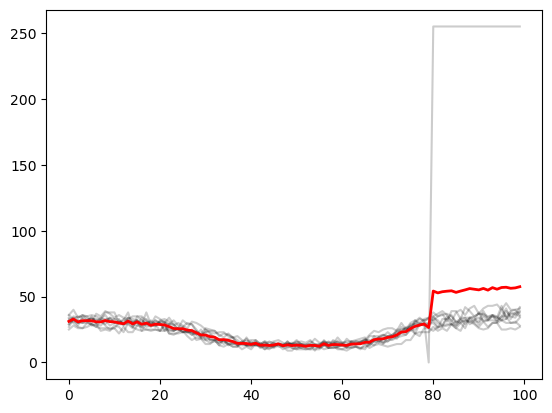

In [98]:
f, ax = plt.subplots()

# Plot all profiles
for idx, profile in vertical_profiles.items():
    ax.plot(profile, color= "k", alpha=0.2)
    
# Convert dict of profiles to 2D array (each row is one profile)
profiles_all = np.vstack(list(vertical_profiles.values()))

ax.plot(np.mean(profiles_all, axis=0), color="r", linewidth=2)

print(f"Shape: {profiles_all.shape}")  # Will show (n_profiles, n_pixels)

In [99]:
profiles_all

array([[ 32,  30,  27,  26,  30,  29,  29,  24,  25,  24,  28,  27,  23,
         30,  27,  25,  24,  25,  25,  25,  24,  29,  22,  22,  22,  23,
         23,  23,  17,  18,  14,  14,  17,  13,  17,  13,  15,  13,  10,
         12,  10,  14,  13,  15,  13,  12,  14,  12,   9,   9,  13,  11,
         13,  13,  13,  12,  15,  11,  11,  12,  14,  11,  12,  12,  11,
         12,  13,  16,  15,  18,  16,  20,  18,  23,  23,  28,  22,  29,
         28,  29,  32,  27,  27,  28,  29,  26,  24,  31,  31,  29,  26,
         25,  26,  30,  30,  25,  25,  26,  25,  27],
       [ 27,  33,  28,  35,  35,  30,  37,  35,  39,  37,  34,  36,  34,
         33,  35,  35,  35,  32,  28,  30,  31,  31,  24,  24,  26,  32,
         29,  29,  23,  22,  26,  25,  24,  21,  19,  22,  19,  13,  16,
         13,  13,  14,  12,  10,  11,  11,  13,  10,  12,  11,  10,  10,
         10,  11,  12,  11,  13,  11,  11,  11,  10,   9,  11,  12,  10,
         14,  11,  13,  17,  15,  20,  19,  25,  25,  26,  25,  25,  2

In [100]:
import numpy as np
from typing import Iterable, Tuple, Dict


def centroid_from_points(xy: np.ndarray) -> Tuple[float, float]:
    """Centroid of a set of points (x,y) with uniform weight.
    xy: array-like of shape (N, 2) where columns are [x, y].
    Returns (cx, cy) as floats.
    """
    xy = np.asarray(xy, dtype=float)
    if xy.ndim != 2 or xy.shape[1] != 2 or xy.size == 0:
        raise ValueError("xy must be (N,2) non-empty array")
    cx, cy = xy[:, 0].mean(), xy[:, 1].mean()
    return float(cx), float(cy)


def centroid_from_polygon(xy: np.ndarray) -> Tuple[float, float]:
    """Area-weighted centroid of a simple polygon via shoelace formula.
    xy: array-like of shape (M, 2) with polygon vertices [x, y].
        The polygon can be open (first != last); it'll be closed internally.
    Returns (cx, cy). If area is ~0, falls back to mean of vertices.
    """
    xy = np.asarray(xy, dtype=float)
    if xy.ndim != 2 or xy.shape[1] != 2 or xy.size < 6:
        # <3 points -> degenerate; use mean
        return centroid_from_points(xy)
    # Close polygon if needed
    if not np.allclose(xy[0], xy[-1]):
        xy = np.vstack([xy, xy[0]])
    x = xy[:, 0]
    y = xy[:, 1]
    cross = x[:-1] * y[1:] - x[1:] * y[:-1]
    A = 0.5 * cross.sum()
    if np.isclose(A, 0.0):
        return centroid_from_points(xy[:-1])
    cx = (1.0 / (6.0 * A)) * ((x[:-1] + x[1:]) * cross).sum()
    cy = (1.0 / (6.0 * A)) * ((y[:-1] + y[1:]) * cross).sum()
    return float(cx), float(cy)


def centroids_from_label_image(labels: np.ndarray) -> Dict[int, Tuple[float, float]]:
    """Centroid (center of mass of pixels) for each positive integer label.
    labels: 2D array with background=0 and object labels >=1.
    Returns a dict {label: (cx, cy)} with x as columns, y as rows.
    """
    labels = np.asarray(labels)
    result: Dict[int, Tuple[float, float]] = {}
    max_label = int(labels.max()) if labels.size else 0
    for lab in range(1, max_label + 1):
        mask = labels == lab
        if not np.any(mask):
            continue
        ys, xs = np.nonzero(mask)
        cy, cx = ys.mean(), xs.mean()
        result[lab] = (float(cx), float(cy))
    return result

In [101]:
# Optional: recompute using the helper for consistency and save to CSV
helper_centroids = centroids_from_label_image(masks)

# Convert to DataFrame and save
import pandas as pd
centroid_df = (
    pd.DataFrame(
        [(lab, xy[0], xy[1]) for lab, xy in helper_centroids.items()],
        columns=["label", "cx", "cy"],
    )
    .sort_values("label")
    .reset_index(drop=True)
)
output_csv = DATAFOLDER / (filename.stem + "_centroids.csv")
centroid_df.to_csv(output_csv, index=False)
output_csv

WindowsPath('../data/ME_PLVAP1_seg_centroids.csv')

In [102]:
# Extract profiles normalized to mask size with 10-pixel margins
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates

margin_pixels = 10
num_samples = 100

# Storage for size-normalized profiles
norm_horizontal_profiles = {}
norm_vertical_profiles = {}
norm_diagonal_45_profiles = {}
norm_diagonal_135_profiles = {}

masks = data["masks"]

for label in range(1, int(masks.max()) + 1):
    single_mask = masks == label
    if not np.any(single_mask):
        continue
    
    # Get mask bounds
    ys, xs = np.nonzero(single_mask)
    cy = float(ys.mean())
    cx = float(xs.mean())
    
    # Calculate mask extent in x and y directions
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    mask_width = x_max - x_min
    mask_height = y_max - y_min
    
    # --- HORIZONTAL PROFILE (scaled to mask width + margins) ---
    profile_x_start = cx - (mask_width / 2) - margin_pixels
    profile_x_end = cx + (mask_width / 2) + margin_pixels
    
    if profile_x_start >= 0 and profile_x_end < image.shape[1]:
        # Extract the raw profile
        x_coords = np.linspace(profile_x_start, profile_x_end, num_samples)
        y_coords = np.full_like(x_coords, cy)
        
        h_profile = map_coordinates(image, [y_coords, x_coords], order=1)
        norm_horizontal_profiles[label] = h_profile
    
    # --- VERTICAL PROFILE (scaled to mask height + margins) ---
    profile_y_start = cy - (mask_height / 2) - margin_pixels
    profile_y_end = cy + (mask_height / 2) + margin_pixels
    
    if profile_y_start >= 0 and profile_y_end < image.shape[0]:
        # Extract the raw profile
        y_coords = np.linspace(profile_y_start, profile_y_end, num_samples)
        x_coords = np.full_like(y_coords, cx)
        
        v_profile = map_coordinates(image, [y_coords, x_coords], order=1)
        norm_vertical_profiles[label] = v_profile
    
    # --- DIAGONAL 45° PROFILE (scaled to mask diagonal + margins) ---
    diag_length = np.sqrt(mask_width**2 + mask_height**2) / 2
    profile_diag_len = diag_length + margin_pixels
    
    x_coords_45 = np.linspace(cx - profile_diag_len, cx + profile_diag_len, num_samples)
    y_coords_45 = np.linspace(cy - profile_diag_len, cy + profile_diag_len, num_samples)
    
    if (x_coords_45.min() >= 0 and x_coords_45.max() < image.shape[1] and
        y_coords_45.min() >= 0 and y_coords_45.max() < image.shape[0]):
        d45_profile = map_coordinates(image, [y_coords_45, x_coords_45], order=1)
        norm_diagonal_45_profiles[label] = d45_profile
    
    # --- DIAGONAL 135° PROFILE (scaled to mask diagonal + margins) ---
    x_coords_135 = np.linspace(cx - profile_diag_len, cx + profile_diag_len, num_samples)
    y_coords_135 = np.linspace(cy + profile_diag_len, cy - profile_diag_len, num_samples)
    
    if (x_coords_135.min() >= 0 and x_coords_135.max() < image.shape[1] and
        y_coords_135.min() >= 0 and y_coords_135.max() < image.shape[0]):
        d135_profile = map_coordinates(image, [y_coords_135, x_coords_135], order=1)
        norm_diagonal_135_profiles[label] = d135_profile

print(f"Size-normalized profiles extracted:")
print(f"  Horizontal: {len(norm_horizontal_profiles)} profiles")
print(f"  Vertical: {len(norm_vertical_profiles)} profiles")
print(f"  Diagonal 45°: {len(norm_diagonal_45_profiles)} profiles")
print(f"  Diagonal 135°: {len(norm_diagonal_135_profiles)} profiles")

Size-normalized profiles extracted:
  Horizontal: 11 profiles
  Vertical: 10 profiles
  Diagonal 45°: 10 profiles
  Diagonal 135°: 10 profiles


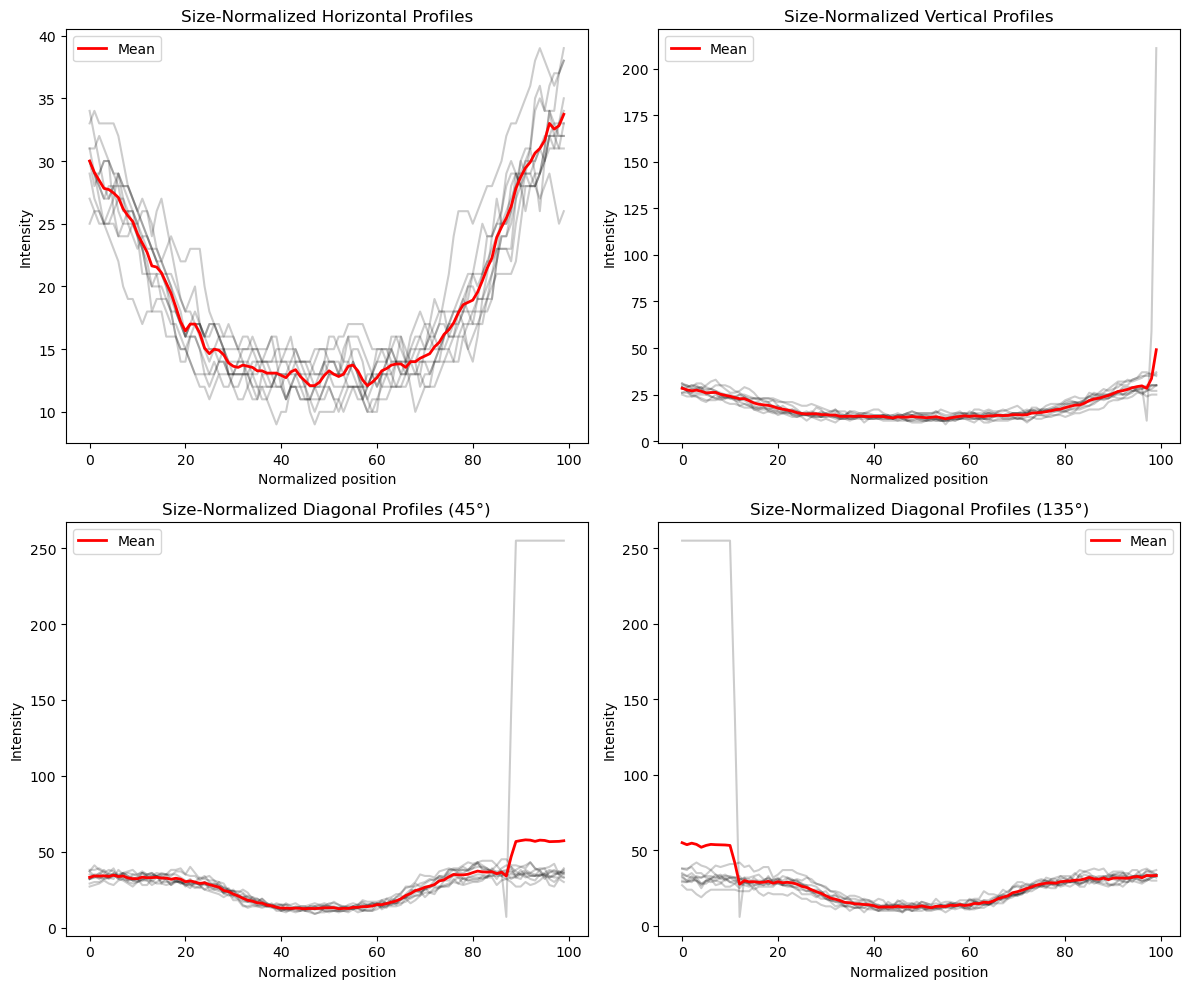

In [103]:
# Visualize size-normalized profiles
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Horizontal profiles
ax = axes[0, 0]
for idx, profile in norm_horizontal_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if norm_horizontal_profiles:
    h_array = np.vstack(list(norm_horizontal_profiles.values()))
    ax.plot(np.mean(h_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Size-Normalized Horizontal Profiles')
ax.set_xlabel('Normalized position')
ax.set_ylabel('Intensity')
ax.legend()

# Vertical profiles
ax = axes[0, 1]
for idx, profile in norm_vertical_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if norm_vertical_profiles:
    v_array = np.vstack(list(norm_vertical_profiles.values()))
    ax.plot(np.mean(v_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Size-Normalized Vertical Profiles')
ax.set_xlabel('Normalized position')
ax.set_ylabel('Intensity')
ax.legend()

# 45-degree diagonal profiles
ax = axes[1, 0]
for idx, profile in norm_diagonal_45_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if norm_diagonal_45_profiles:
    d45_array = np.vstack(list(norm_diagonal_45_profiles.values()))
    ax.plot(np.mean(d45_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Size-Normalized Diagonal Profiles (45°)')
ax.set_xlabel('Normalized position')
ax.set_ylabel('Intensity')
ax.legend()

# 135-degree diagonal profiles
ax = axes[1, 1]
for idx, profile in norm_diagonal_135_profiles.items():
    ax.plot(profile, color='k', alpha=0.2)
if norm_diagonal_135_profiles:
    d135_array = np.vstack(list(norm_diagonal_135_profiles.values()))
    ax.plot(np.mean(d135_array, axis=0), color='r', linewidth=2, label='Mean')
ax.set_title('Size-Normalized Diagonal Profiles (135°)')
ax.set_xlabel('Normalized position')
ax.set_ylabel('Intensity')
ax.legend()

plt.tight_layout()
plt.show()

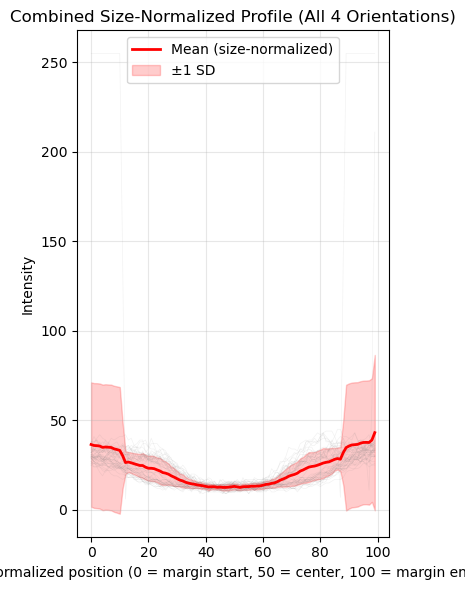

Total size-normalized profiles combined: 41
Combined array shape: (41, 100)
Mean profile shape: (100,)


In [104]:
# Combine all size-normalized profiles
norm_all_profiles = []

if norm_horizontal_profiles:
    norm_all_profiles.extend(list(norm_horizontal_profiles.values()))
if norm_vertical_profiles:
    norm_all_profiles.extend(list(norm_vertical_profiles.values()))
if norm_diagonal_45_profiles:
    norm_all_profiles.extend(list(norm_diagonal_45_profiles.values()))
if norm_diagonal_135_profiles:
    norm_all_profiles.extend(list(norm_diagonal_135_profiles.values()))

# Convert to 2D array and compute statistics
norm_combined_array = np.vstack(norm_all_profiles)
norm_combined_mean = np.mean(norm_combined_array, axis=0)
norm_combined_std = np.std(norm_combined_array, axis=0)

# Visualize
fig, ax = plt.subplots(figsize=(4, 6))

# Plot all individual profiles
for profile in norm_all_profiles:
    ax.plot(profile, color='gray', alpha=0.1, linewidth=0.5)

# Plot mean with standard deviation band
x = np.arange(len(norm_combined_mean))
ax.plot(norm_combined_mean, color='red', linewidth=2, label='Mean (size-normalized)')
ax.fill_between(x, 
                 norm_combined_mean - norm_combined_std, 
                 norm_combined_mean + norm_combined_std, 
                 color='red', alpha=0.2, label='±1 SD')

ax.set_title('Combined Size-Normalized Profile (All 4 Orientations)')
ax.set_xlabel('Normalized position (0 = margin start, 50 = center, 100 = margin end)')
ax.set_ylabel('Intensity')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total size-normalized profiles combined: {len(norm_all_profiles)}")
print(f"Combined array shape: {norm_combined_array.shape}")
print(f"Mean profile shape: {norm_combined_mean.shape}")

In [9]:
def remove_artifacts(profiles_dict, max_gradient_threshold=50, max_std_multiplier=3):
    """
    Remove profiles with artifacts (large jumps or extreme values).
    
    Parameters:
    -----------
    profiles_dict : dict
        Dictionary of {label: profile_array}
    max_gradient_threshold : float
        Maximum allowed gradient (intensity change between adjacent pixels)
    max_std_multiplier : float
        Number of standard deviations from mean profile to consider as outlier
    
    Returns:
    --------
    clean_profiles : dict
        Dictionary with artifact profiles removed
    removed_labels : list
        List of labels that were removed
    """
    if not profiles_dict:
        return {}, []
    
    profiles_array = np.array(list(profiles_dict.values()))
    labels = list(profiles_dict.keys())
    
    removed_labels = []
    clean_profiles = {}
    
    # Criterion 1: Check for large gradients (sudden jumps)
    for label, profile in profiles_dict.items():
        gradient = np.abs(np.diff(profile))
        max_gradient = np.max(gradient)
        
        if max_gradient > max_gradient_threshold:
            removed_labels.append((label, f'large gradient: {max_gradient:.1f}'))
            continue
        
        # Criterion 2: Check if profile is an outlier compared to mean
        mean_profile = np.mean(profiles_array, axis=0)
        deviation = np.mean(np.abs(profile - mean_profile))
        std_deviation = np.std([np.mean(np.abs(p - mean_profile)) for p in profiles_array])
        
        if deviation > max_std_multiplier * std_deviation:
            removed_labels.append((label, f'outlier: deviation={deviation:.1f}'))
            continue
        
        # Profile passes all checks
        clean_profiles[label] = profile
    
    return clean_profiles, removed_labels


print("Artifact removal function defined successfully!")

Artifact removal function defined successfully!


In [12]:
# Apply artifact removal to original fixed-size profiles
# First, let's check the gradient distribution to set a good threshold
all_gradients = []
for profiles in [horizontal_profiles, vertical_profiles, diagonal_45_profiles, diagonal_135_profiles]:
    for profile in profiles.values():
        max_grad = np.max(np.abs(np.diff(profile)))
        all_gradients.append(max_grad)

gradient_array = np.array(all_gradients)
print(f"Gradient statistics:")
print(f"  Min: {gradient_array.min():.1f}")
print(f"  25th percentile: {np.percentile(gradient_array, 25):.1f}")
print(f"  Median: {np.median(gradient_array):.1f}")
print(f"  75th percentile: {np.percentile(gradient_array, 75):.1f}")
print(f"  95th percentile: {np.percentile(gradient_array, 95):.1f}")
print(f"  Max: {gradient_array.max():.1f}")

# Use 95th percentile as threshold (or adjust based on above stats)
gradient_threshold = np.percentile(gradient_array, 95)
print(f"\nUsing gradient threshold: {gradient_threshold:.1f}")

print("\n" + "=" * 60)
print("ARTIFACT REMOVAL - ORIGINAL FIXED-SIZE PROFILES")
print("=" * 60)

clean_h, removed_h = remove_artifacts(horizontal_profiles, max_gradient_threshold=gradient_threshold, max_std_multiplier=5)
clean_v, removed_v = remove_artifacts(vertical_profiles, max_gradient_threshold=gradient_threshold, max_std_multiplier=5)
clean_45, removed_45 = remove_artifacts(diagonal_45_profiles, max_gradient_threshold=gradient_threshold, max_std_multiplier=5)
clean_135, removed_135 = remove_artifacts(diagonal_135_profiles, max_gradient_threshold=gradient_threshold, max_std_multiplier=5)

print(f"\nHorizontal: {len(horizontal_profiles)} → {len(clean_h)} (removed {len(removed_h)})")
if removed_h:
    for label, reason in removed_h:
        print(f"  - Label {label}: {reason}")

print(f"\nVertical: {len(vertical_profiles)} → {len(clean_v)} (removed {len(removed_v)})")
if removed_v:
    for label, reason in removed_v:
        print(f"  - Label {label}: {reason}")

print(f"\nDiagonal 45°: {len(diagonal_45_profiles)} → {len(clean_45)} (removed {len(removed_45)})")
if removed_45:
    for label, reason in removed_45:
        print(f"  - Label {label}: {reason}")

print(f"\nDiagonal 135°: {len(diagonal_135_profiles)} → {len(clean_135)} (removed {len(removed_135)})")
if removed_135:
    for label, reason in removed_135:
        print(f"  - Label {label}: {reason}")

# Combine cleaned profiles
clean_all_profiles = []
if clean_h:
    clean_all_profiles.extend(list(clean_h.values()))
if clean_v:
    clean_all_profiles.extend(list(clean_v.values()))
if clean_45:
    clean_all_profiles.extend(list(clean_45.values()))
if clean_135:
    clean_all_profiles.extend(list(clean_135.values()))

# Count total original profiles
total_original = len(horizontal_profiles) + len(vertical_profiles) + len(diagonal_45_profiles) + len(diagonal_135_profiles)

if clean_all_profiles:
    clean_combined_array = np.vstack(clean_all_profiles)
    clean_combined_mean = np.mean(clean_combined_array, axis=0)
    clean_combined_std = np.std(clean_combined_array, axis=0)
    
    print(f"\n{'=' * 60}")
    print(f"SUMMARY: {total_original} → {len(clean_all_profiles)} profiles")
    print(f"{'=' * 60}")
else:
    print("\nWarning: No profiles remaining after artifact removal!")

Gradient statistics:
  Min: 255.0
  25th percentile: 255.0
  Median: 255.0
  75th percentile: 255.0
  95th percentile: 255.0
  Max: 255.0

Using gradient threshold: 255.0

ARTIFACT REMOVAL - ORIGINAL FIXED-SIZE PROFILES

Horizontal: 11 → 3 (removed 8)
  - Label 1: outlier: deviation=2.2
  - Label 3: outlier: deviation=2.9
  - Label 4: outlier: deviation=2.8
  - Label 5: outlier: deviation=3.2
  - Label 7: outlier: deviation=2.4
  - Label 9: outlier: deviation=2.8
  - Label 10: outlier: deviation=2.2
  - Label 11: outlier: deviation=2.5

Vertical: 10 → 10 (removed 0)

Diagonal 45°: 10 → 10 (removed 0)

Diagonal 135°: 10 → 10 (removed 0)

SUMMARY: 41 → 33 profiles


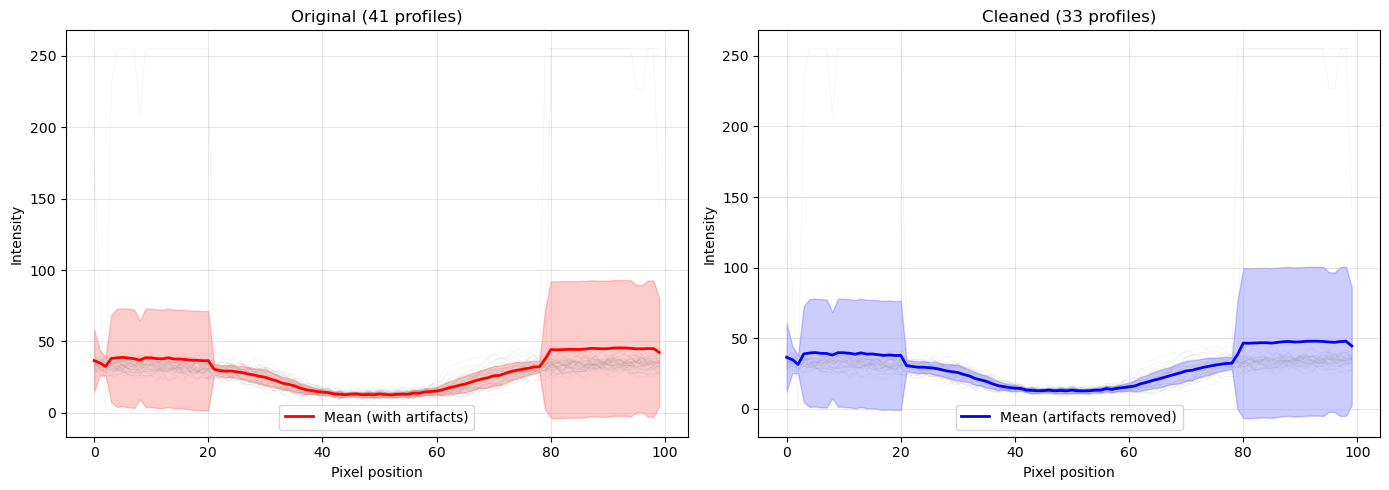


Artifact removal: 41 → 33 profiles (8 removed)


In [15]:
# Compare original vs cleaned profiles
# First create the original combined profile
all_profiles_original = []
all_profiles_original.extend(list(horizontal_profiles.values()))
all_profiles_original.extend(list(vertical_profiles.values()))
all_profiles_original.extend(list(diagonal_45_profiles.values()))
all_profiles_original.extend(list(diagonal_135_profiles.values()))

combined_array_original = np.vstack(all_profiles_original)
combined_mean_original = np.mean(combined_array_original, axis=0)
combined_std_original = np.std(combined_array_original, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original combined profile
ax = axes[0]
for profile in all_profiles_original:
    ax.plot(profile, color='gray', alpha=0.1, linewidth=0.5)
x = np.arange(len(combined_mean_original))
ax.plot(combined_mean_original, color='red', linewidth=2, label='Mean (with artifacts)')
ax.fill_between(x, 
                 combined_mean_original - combined_std_original, 
                 combined_mean_original + combined_std_original, 
                 color='red', alpha=0.2)
ax.set_title(f'Original ({len(all_profiles_original)} profiles)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()
ax.grid(True, alpha=0.3)

# Cleaned combined profile
ax = axes[1]
for profile in clean_all_profiles:
    ax.plot(profile, color='gray', alpha=0.1, linewidth=0.5)
x = np.arange(len(clean_combined_mean))
ax.plot(clean_combined_mean, color='blue', linewidth=2, label='Mean (artifacts removed)')
ax.fill_between(x, 
                 clean_combined_mean - clean_combined_std, 
                 clean_combined_mean + clean_combined_std, 
                 color='blue', alpha=0.2)
ax.set_title(f'Cleaned ({len(clean_all_profiles)} profiles)')
ax.set_xlabel('Pixel position')
ax.set_ylabel('Intensity')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nArtifact removal: {len(all_profiles_original)} → {len(clean_all_profiles)} profiles ({len(all_profiles_original)-len(clean_all_profiles)} removed)")